# DeepLearning

## Todo tasks
1. Map the data to the specified training splits
2. Preprocess the video data
3. Build or use a model
4. Prepare dataloaders
5. train the model
6. evaluate performance

In [2]:
# import necessary libraries
import time
import os
import cv2 as cv
import numpy as np
import torch
import sys
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
print(torch.cuda.is_available())

2.0.0
False


## 1. Map the data to the specified training splits


In [5]:
def load_class_index(path):
    """Returns class labels: in a numeric form. This is used for parsing 'classInd.txt'
        class_map = {
            class_name: idx,
            'ApplyEyeMakeUp': 0,
            ... : 1,
        }

    """
    class_map = {}
    with open(path, 'r') as f:
        for line in f:  # read each line in the .txt file
            idx, class_name = line.strip().split() # '1 ApplyEyeMakeup' -> becomes '1' and 'ApplyEyeMakeup'
            class_map[class_name] = int(idx) - 1   # idx (value) starts at 0, with the class_name (key) of 'ApplyEyeMakeup'

    return class_map

def load_split_file(file_path, base_dir="UCF-101", has_labels=False):
    """store details in video_list, this function reads a file path - can be either test or train, and assign directory list
        in the form of: [(path, action_label),....]"""
    # file_df = pd.read_csv(file_path, header=None, sep=' ')
    # file_df['label'] = 
    # video_list = []
    video_list = []
    with open(file_path, 'r') as f:
        for line in f: # loop through each file
            parts = line.strip().split()
            relative_path = parts[0]
            full_path = os.path.join(base_dir, relative_path).replace("\\", "/") # needs to adjust the join slash. joins "UCF-101" with 'ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi' -> 'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi'
            if has_labels: # the trainlist.txt has labels
                label = int(parts[1]) - 1

                video_list.append((full_path, label)) # add to video_list in the form of ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi', 'ApplyEyeMakeup') --- so each video corresponds to an action label.
            else: # the testlist.txt does not include labels
                class_name = relative_path.split('/')[0] # class_name takes the split of 'ApplyEyeMakeup'
                video_list.append((full_path, class_name))
    return video_list


class_map = load_class_index('ucfTrainTestlist/classInd.txt')

train_list = load_split_file('ucfTrainTestlist/trainlist01.txt', has_labels=True)
train_dataset = train_list


test_list_raw = load_split_file('ucfTrainTestlist/testlist01.txt', has_labels=False) # testlist has no label
test_dataset = [(path, class_map[class_name]) for path, class_name in test_list_raw] # replace the action name with the index assigned in class_map

print(train_dataset[:5])
print(test_dataset[:5])


[('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi', 0)]
[('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi', 0), ('UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi', 0)]


## 2: Video preprocessing - cut frames, resize, normalise images

In [6]:
# 2: Preprocess the videos
def load_video(path: str,
               num_frames:int=16,
               size: tuple=(105, 105)):
    """This function reads frames from path, sample a fixed number, resize, normalise and convert to tensor, ready for ML tasks

    Args:
        path (_type_): path to the video
        num_frames (int, optional): how many frames user wants to retain. Defaults to 16.
        size (tuple, optional): how big are they frames. Defaults to (105, 105).
    """
    path = path.replace("\\", "/")
    cap = cv.VideoCapture(path) # video object created - to read frame by frame
    # check if vid opens
    if not cap.isOpened():
        print(f"[ERROR] Could not open video: {path}")
        return None

    total_f = cap.get(cv.CAP_PROP_FRAME_COUNT) # how many frames in the vid

    frame_indices = np.linspace(0, total_f - 1, num_frames).astype(int) # evenly spaced indices to slice these frames only

    # loop through the video, grab only the specified frames
    frames_saved = []
    for x in frame_indices:
        frame = cap.set(cv.CAP_PROP_POS_FRAMES, x) # go to frame x
        success, frame = cap.read() # get that frame at x

        if not success or frame is None:
            print(f"[Warning] Could not read frame at index {x}")
            continue # for now, pass this frame

        frame = cv.resize(frame, size) # resize the frame - based on the args
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB) # change opencv BGR format to RGB
        frames_saved.append(frame)

    cap.release() # close the reading

    # if too few frames
    while len(frames_saved) < num_frames:
        frames_saved.append(frames_saved[-1]) # unless frames_saved == num_frames, continue to add the last frame onto it

    # Tensor conversion
    frames_np = np.stack(frames_saved) # combines all np array (each img) to shape: (frame_num(D), img height (H), img width (W), channels (C))
    frames_np = frames_np / 255 # normalise pixel values: to [0,1]
    # rearrange frames_np to match Tensor format (D,C,H,W)
    frames_np = np.transpose(frames_np, (0,3,1,2))

    # torch conversion
    video_tensor = torch.tensor(frames_np, dtype=torch.float32)

     #debug
    return video_tensor


# save preprocessed video tensors to disk (once) - otherwise the batches will be loaded every single time
def save_video_tensors(video_paths, labels, save_dir="video_cache", num_frames=16, size=(105,105)):
    os.makedirs(save_dir,exist_ok=True)

    for path, label in tqdm(zip(video_paths, labels), total=len(video_paths), desc=f"Caching to {save_dir}"):
        video_tensor = load_video(path, num_frames=num_frames, size=size)
        if video_tensor is None:
            continue
        filename = os.path.splitext(os.path.basename(path))[0]
        save_path = os.path.join(save_dir, f"{filename}.pt")
        torch.save({'video': video_tensor, 'label': label}, save_path)


# unzip the dictionary of train_list and test_list
train_video_paths, train_labels = zip(*train_dataset)
test_video_paths, test_labels = zip(*test_dataset)

save_video_tensors(train_video_paths, train_labels, save_dir="video_cache/train")
save_video_tensors(test_video_paths, test_labels, save_dir="video_cache/test")

Caching to video_cache/train:   6%|▌         | 590/9537 [01:16<05:28, 27.26it/s]

[Warning] Could not read frame at index 72
[Warning] Could not read frame at index 62
[Warning] Could not read frame at index 67


Caching to video_cache/train:   7%|▋         | 707/9537 [01:19<03:01, 48.60it/s]

[Warning] Could not read frame at index 277
[Warning] Could not read frame at index 299


Caching to video_cache/train:   8%|▊         | 727/9537 [01:19<03:34, 40.98it/s]

[Warning] Could not read frame at index 527
[Warning] Could not read frame at index 517
[Warning] Could not read frame at index 130
[Warning] Could not read frame at index 95
[Warning] Could not read frame at index 470
[Warning] Could not read frame at index 345


Caching to video_cache/train:   8%|▊         | 744/9537 [01:20<03:09, 46.30it/s]

[Warning] Could not read frame at index 145


Caching to video_cache/train:  26%|██▌       | 2502/9537 [02:51<02:22, 49.39it/s]

[Warning] Could not read frame at index 182
[Warning] Could not read frame at index 384


Caching to video_cache/train:  33%|███▎      | 3101/9537 [03:13<02:17, 46.77it/s]

[Warning] Could not read frame at index 99


Caching to video_cache/train:  33%|███▎      | 3152/9537 [03:14<02:07, 49.90it/s]

[Warning] Could not read frame at index 302
[Warning] Could not read frame at index 299
[Warning] Could not read frame at index 347


Caching to video_cache/train:  33%|███▎      | 3169/9537 [03:15<02:04, 51.01it/s]

[Warning] Could not read frame at index 148
[Warning] Could not read frame at index 158


Caching to video_cache/train:  42%|████▏     | 3988/9537 [04:02<01:46, 51.96it/s]

[Warning] Could not read frame at index 241


Caching to video_cache/train:  47%|████▋     | 4490/9537 [04:18<01:40, 50.05it/s]

[Warning] Could not read frame at index 119


Caching to video_cache/train:  49%|████▊     | 4649/9537 [04:22<01:53, 42.95it/s]

[Warning] Could not read frame at index 371


Caching to video_cache/train:  83%|████████▎ | 7930/9537 [06:39<00:34, 46.46it/s]

[Warning] Could not read frame at index 239


Caching to video_cache/train:  84%|████████▎ | 7974/9537 [06:40<00:32, 48.43it/s]

[Warning] Could not read frame at index 239
[Warning] Could not read frame at index 415


Caching to video_cache/train:  84%|████████▍ | 7994/9537 [06:40<00:32, 47.97it/s]

[Warning] Could not read frame at index 359
[Warning] Could not read frame at index 299


Caching to video_cache/train:  88%|████████▊ | 8437/9537 [07:09<00:22, 48.36it/s]

[Warning] Could not read frame at index 317


Caching to video_cache/train:  91%|█████████ | 8674/9537 [07:23<00:15, 55.68it/s]

[Warning] Could not read frame at index 297
[Warning] Could not read frame at index 321


Caching to video_cache/train:  91%|█████████▏| 8716/9537 [07:24<00:15, 52.92it/s]

[Warning] Could not read frame at index 269
[Warning] Could not read frame at index 95


Caching to video_cache/train:  93%|█████████▎| 8858/9537 [07:27<00:13, 48.79it/s]

[Warning] Could not read frame at index 348


Caching to video_cache/train:  96%|█████████▌| 9147/9537 [07:41<00:07, 52.17it/s]

[Warning] Could not read frame at index 112
[Warning] Could not read frame at index 119
[Warning] Could not read frame at index 207


Caching to video_cache/train:  96%|█████████▌| 9171/9537 [07:42<00:07, 50.76it/s]

[Warning] Could not read frame at index 239


Caching to video_cache/train:  96%|█████████▋| 9189/9537 [07:42<00:06, 51.07it/s]

[Warning] Could not read frame at index 229
[Warning] Could not read frame at index 119


Caching to video_cache/train:  97%|█████████▋| 9239/9537 [07:43<00:06, 49.05it/s]

[Warning] Could not read frame at index 239
[Warning] Could not read frame at index 203


Caching to video_cache/test:   6%|▌         | 236/3783 [00:21<01:48, 32.75it/s]

[Warning] Could not read frame at index 93


Caching to video_cache/test:   7%|▋         | 272/3783 [00:21<01:09, 50.59it/s]

[Warning] Could not read frame at index 137
[Warning] Could not read frame at index 87


Caching to video_cache/test:  26%|██▌       | 978/3783 [00:56<01:03, 44.21it/s]

[Warning] Could not read frame at index 187


Caching to video_cache/test:  33%|███▎      | 1237/3783 [01:06<01:14, 34.38it/s]

[Warning] Could not read frame at index 517
[Warning] Could not read frame at index 121


Caching to video_cache/test:  33%|███▎      | 1261/3783 [01:06<00:52, 48.43it/s]

[Warning] Could not read frame at index 119
[Warning] Could not read frame at index 131


Caching to video_cache/test:  33%|███▎      | 1266/3783 [01:06<00:56, 44.84it/s]

[Warning] Could not read frame at index 134


Caching to video_cache/test:  83%|████████▎ | 3123/3783 [02:19<00:30, 21.96it/s]

[Warning] Could not read frame at index 501
[Warning] Could not read frame at index 239


Caching to video_cache/test:  83%|████████▎ | 3154/3783 [02:20<00:13, 45.39it/s]

[Warning] Could not read frame at index 239


Caching to video_cache/test:  97%|█████████▋| 3665/3783 [02:41<00:02, 51.45it/s]

[Warning] Could not read frame at index 239


Caching to video_cache/test: 100%|██████████| 3783/3783 [02:47<00:00, 22.52it/s]


## 3: Prepare Data Loader

In [11]:
# 3: Prepare data paths and labels - DataLoader
# we need a list of video file paths (str) and a list of labels (int)
class UFC101Dataset(Dataset):
    def __init__(self, data_list, transform=None) -> None:
        """takes input as the data list created from previous code cell

        Args:
            data_list: list of (video_path, label) tuples
            transform (optional): transform to apply to video tensor. Defaults to None.
        """
        self.data = data_list
        self.transform = transform # intialise on how the data will come in

    def __len__(self):
        return len(self.data) # how many batches to draw

    def __getitem__(self, index): # define how a sample to be loaded
        path, label = self.data[index]
        video = load_video(path) # shape (D, C, H, W)
        if self.transform:
            video = self.transform(video)
        video = video.permute(1,0,2,3) # change shape to (D,C,H,W) into (C,D,H,W). 3D CNN Pytorch expects (batch, C,D,H,W)
        return video, label

# Dataset that load from cache
class UFC101DatasetCached(Dataset):
    def __init__(self, cache_dir) -> None:
        """takes input as the cached data list
        """
        self.files = [os.path.join(cache_dir, f) for f in os.listdir(cache_dir) if f.endswith(".pt")]


    def __len__(self):
        return len(self.files) # how many batches to draw

    def __getitem__(self, index): # define how a sample to be loaded
        data = torch.load(self.files[index])
        return data["video"], data["label"]

## 4: Create dataloader

In [12]:
# 4: Create DataLoader

# set up batch size for training
batch_size = 32


train_dataset = UFC101DatasetCached("video_cache/train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = UFC101DatasetCached("video_cache/test")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


## 5: A simple 3D CNN 
not very good - could be due to too many layers - underfit badly

I tested with a simple 3D CNN - 3 convolutional layers, 3 fully connected layers and got only 23% acc - over 20 epochs

In [13]:
# 5: Set up a simple 3D CNN


class Complex3DCNN(nn.Module):
    """This is a more complext 3D CNN - with 5 3D convolutional blocks, 3 FC layers
    """

    def __init__(self, num_classes):
        super(Complex3DCNN, self).__init__()
        self.dropout = nn.Dropout(p=0.5)

        self.conv_block1 = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2) # output (64, 8, 56, 56)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2) # output (128, 4, 28, 28)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2) # output (256, 2, 14, 14)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 4, 4)) # output (512, 1, 4, 4)
        )
        self.fc6 = nn.Linear(512 * 1 * 4 * 4, 1024)
        self.fc7 = nn.Linear(1024, 512)
        self.fc8 = nn.Linear(512, num_classes)

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        # x = self.conv_block5(x)


        x = x.contiguous().view(x.size(0), -1) # reshape each sample to a flat 1D vector
        x = F.relu(self.fc6(x)) # FC layer 1
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = self.fc8(x)


        return x


## 5.5: Benchmark model - R3D 
very good pretrained model. trained on 400 human actions
change the last classification layer only - just to test the result

In [ ]:
# benchmark model
import torchvision.models.video as video_models
import torch.nn as nn

num_classes = 101  # for UCF101

model = video_models.r3d_18(pretrained=True) # use R3D model
model.fc = nn.Linear(512, num_classes)

for param in model.parameters():
    param.requires_grad = False

# enable gradients for only the final classification layer
for param in model.fc.parameters():
    param.requires_grad = True


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /Users/rinnguyen/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:10<00:00, 13.3MB/s] 


In [ ]:
# 6: train and test


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # put model on GPU/CPU
model = model.to(device) # load model weights to GPU/CPU

# set up optimiser and loss
criterion = nn.CrossEntropyLoss() # multi-class classification. Compares to the true label against the prediction
optimiser = torch.optim.Adam(model.parameters(), lr=0.001) # adjust model weights using gradients

# training loop begins
num_epochs = 5 # just 5 passes - since R3D is a really good model - could increase it higher
train_losses = []
for epoch in range(num_epochs):
    model.train()
    correct = 0 # initialise counter values
    total = 0
    total_loss = 0
    start_time = time.time() # measure time for each epoch
    for batch_idx, (videos, labels) in enumerate(train_loader): # loop through each batch of videos and labels from the train_loader

        videos = videos.permute(0, 2, 1, 3, 4).to(device) # correct shape needed - rearrange the dimensions

        labels = labels.to(device) # moves label tensor to the same device
        if epoch == 0 and batch_idx == 0:  # Only check on the very first batch
            print("Video batch is on:", videos.device)
            print("Model is on:", next(model.parameters()).device)

        optimiser.zero_grad() # clears the gradients from the last step
        outputs = model(videos) # runs a forward pass
        loss = criterion(outputs, labels) # count how wrong the model is
        loss.backward() # using backpropagation to compute gradients
        optimiser.step() # updates weights using those gradients

        total_loss += loss.item() # accumulates the loss

        # accuracy calc
        _, predicted = torch.max(outputs, 1) # predicted shape: (B,). get the class with the highest predicted probability
        correct += (predicted == labels).sum().item() # how many correct predictions
        total += labels.size(0) # total samples processed?

    avg_loss = total_loss / len(train_loader) # average loss
    train_losses.append(avg_loss)

    accuracy = 100 * correct/total # accuracy
    epoch_time = time.time() - start_time # how much time it takes?
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time: .2f} secs")


Video batch is on: cpu
Model is on: cpu


In [12]:
# check test accuracy
model.eval() # disables training-specific layers - like dropout/batchnorms (if used)
correct = 0
total = 0

y_true = []
y_pred = []
video_examples = []
n_examples = 4 # however many frames we want to show

with torch.no_grad(): # disable tracking gradient - for efficiency
    for videos, labels in test_loader: # same as in training - but no backward pass
        videos = videos.permute(0, 2, 1, 3, 4).to(device)
        labels = labels.to(device)
        outputs = model(videos)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)


        labs_cpu = labels.cpu()
        vids_cpu = videos.cpu()
        preds_cpu = predicted.cpu()

        # accumulate for model metrics
        y_true.extend(labs_cpu.tolist())
        y_pred.extend(preds_cpu.tolist())

        if len(video_examples) < n_examples:
            for v, l, p in zip(vids_cpu, labs_cpu, preds_cpu):
                video_examples.append((v, l, p))
                if len(video_examples) >= n_examples: break

print(f"Test Accuracy: {100 * correct / total:.2f}%") # print test acc


Test Accuracy: 80.65%


Total train samples: 9537
Train classes: 101
Total test samples: 3783
Test classes: 101


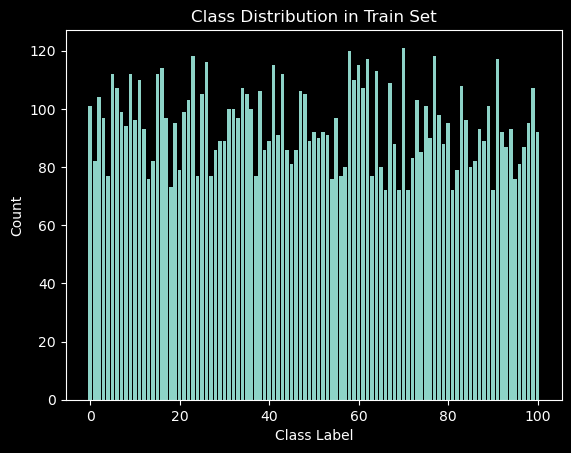

In [ ]:
# === LACKING VISUALISATION ==== need to add more in

# Visualisation
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

print("Total train samples:", len(train_dataset))
print("Train classes:", len(set(train_labels)))

print("Total test samples:", len(test_dataset))
print("Test classes:", len(set(test_labels)))



from collections import Counter
from matplotlib import pyplot as plt

counter = Counter(train_labels)
plt.bar(counter.keys(), counter.values())
plt.title("Class Distribution in Train Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()


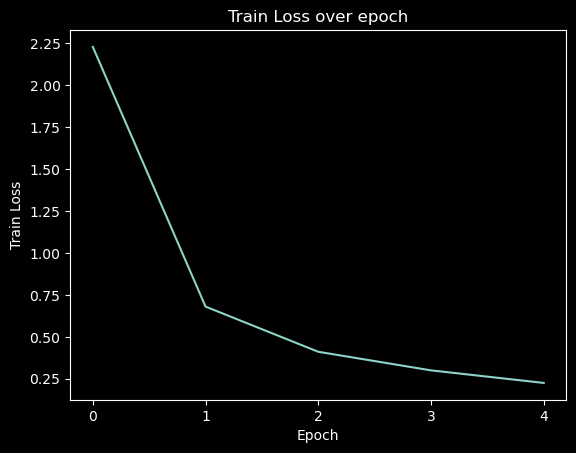

In [14]:
import seaborn as sns

ax = sns.lineplot(train_losses)
ax.set_xticks(range(len(train_losses)))
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss over epoch")
plt.show()

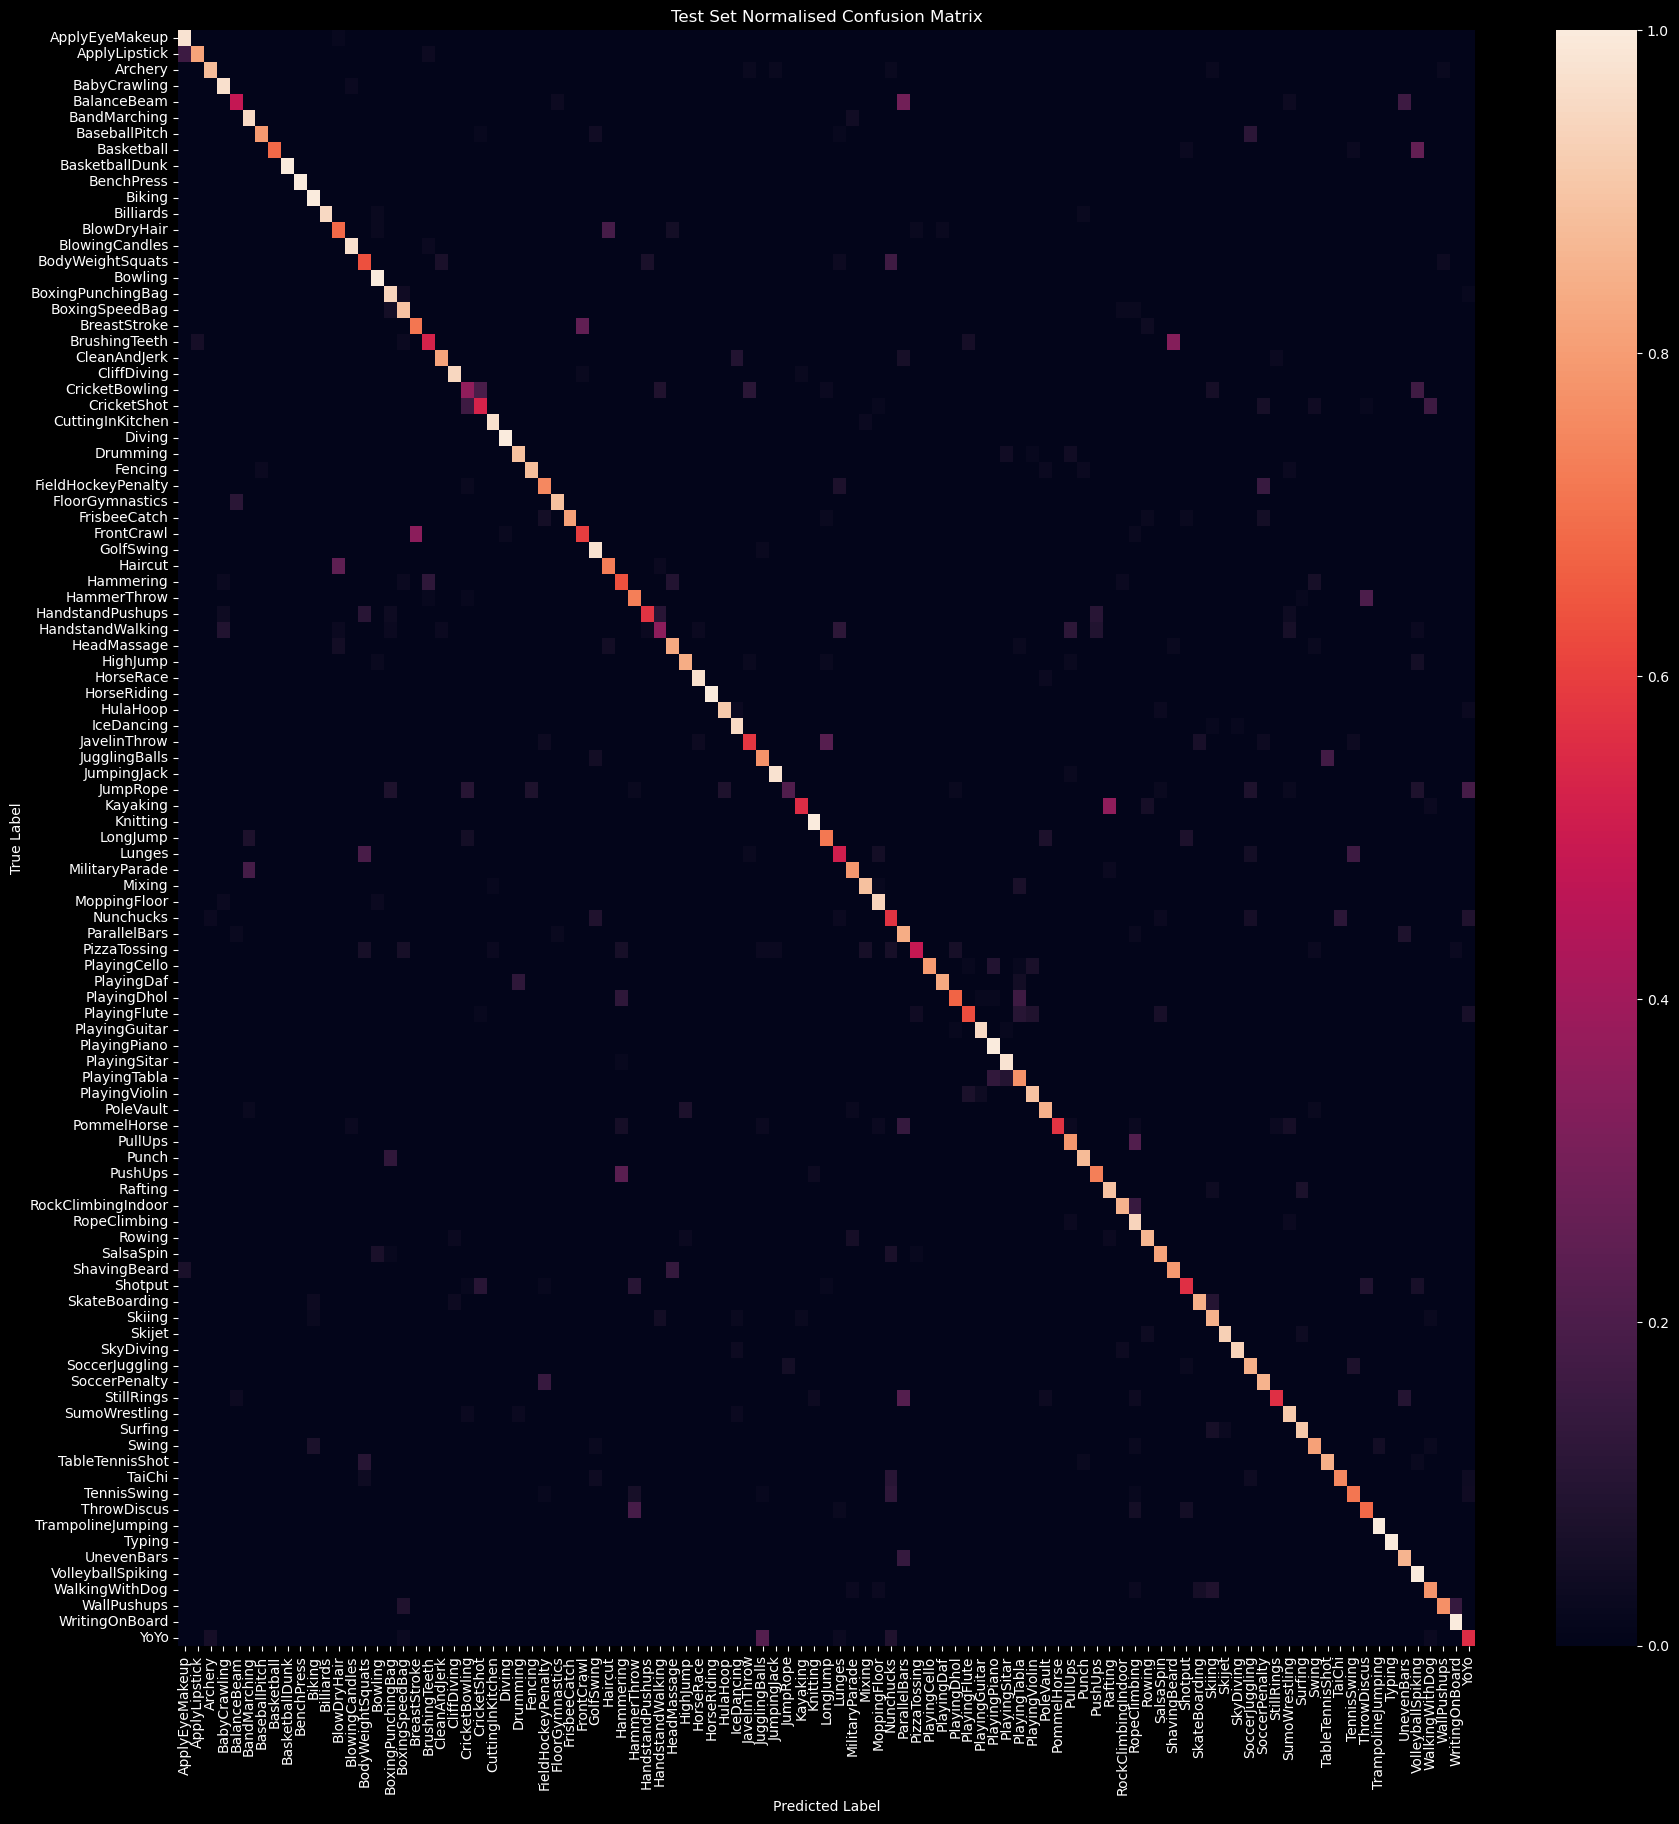

In [48]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix for the test set
# technically we can class_map.keys() but it might be sorted incorrectly?
class_names = [name for name, _ in sorted(class_map.items(), key = lambda val: val[1])]
conf_mat = confusion_matrix(y_true, y_pred, normalize="true", labels = list(range(len(class_map))) )
plt.figure(figsize=(18,18))
ax = sns.heatmap(
    conf_mat,
    xticklabels=class_names,
    yticklabels=class_names
)
plt.tight_layout()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Set Normalised Confusion Matrix")
plt.show()

In [43]:
import matplotlib.animation as animation
import math
import random as random
from IPython.display import HTML

def animate_video_predictions(video_examples, n_examples, max_cols = n_examples):
    selected_examples = random.sample(video_examples, k = n_examples)
    n_cols = min(n_examples, max_cols)
    n_rows = math.ceil(n_examples / max_cols)

    fig, axes = plt.subplots(n_rows, n_cols, constrained_layout=True, figsize = (4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    # set the title for each subplot
    for ax, (_, l, p) in zip(axes, selected_examples):
        pred_colour = "green" if l == p else "red"
        ax.axis("off")
        ax.set_title(
            f"T: {class_names[l]}\n"
            f"P: {class_names[p]}",
            color = pred_colour
        )

    for ax in axes[len(selected_examples):]: ax.axis("off")

    artists = [
        [
            ax.imshow(
                clip[:, frame, :, :].permute(1,2,0).numpy(),
                animated = True
            )
            for ax, (clip, _, _) in zip(axes, selected_examples)
        ]
        for frame in range(video_examples[0][0].shape[1])
    ]

    anim = animation.ArtistAnimation(fig, artists, interval=180, blit=True, repeat=True)
    plt.close()
    return anim

anim = animate_video_predictions(video_examples, 4)
HTML(anim.to_html5_video())